In [1]:
import time
import matplotlib.pyplot as plt
import cantera as ct

print(f"Running Cantera version: {ct.__version__}")

Running Cantera version: 3.1.0


In [2]:
gas = ct.Solution("data/n-hexane-NUIG-2015.yaml")

/tmp/ipykernel_42835/2273275873.py:1: UserWarning: NasaPoly2::validate: 
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  gas = ct.Solution("data/n-hexane-NUIG-2015.yaml")
/tmp/ipykernel_42835/2273275873.py:1: UserWarning: NasaPoly2::validate: 
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.5046684
	Value computed using high-temperature polynomial: 107.34847808033332

  gas = ct.Solution("data/n-hexane-NUIG-2015.yaml")


In [3]:
reactor_temperature = 925  # Kelvin
reactor_pressure = 1.046138 * ct.one_atm  # in atm. This equals 1.06 bars
inlet_concentrations = {"NC7H16": 0.005, "O2": 0.0275, "HE": 0.9675}
gas.TPX = reactor_temperature, reactor_pressure, inlet_concentrations

residence_time = 2  # s
reactor_volume = 30.5 * (1e-2) ** 3  # m3

In [4]:
fuel_air_mixture_tank = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

stirred_reactor = ct.IdealGasMoleReactor(gas, energy="off", volume=reactor_volume)

mass_flow_controller = ct.MassFlowController(
    upstream=fuel_air_mixture_tank,
    downstream=stirred_reactor,
    mdot=stirred_reactor.mass / residence_time,
)

pressure_regulator = ct.PressureController(
    upstream=stirred_reactor,
    downstream=exhaust,
    primary=mass_flow_controller,
    K=1e-3,
)

reactor_network = ct.ReactorNet([stirred_reactor])

In [5]:
# Define all the temperatures at which we will run simulations. These should overlap
# with the values reported in the paper as much as possible
T = [650, 700, 750, 775, 825, 850, 875, 925, 950, 1075, 1100]

# Create a SolutionArray to store values for the above points
temp_dependence = ct.SolutionArray(gas)

In [6]:
concentrations = inlet_concentrations

for reactor_temperature in T:
    # Use concentrations from the previous iteration to speed up convergence
    gas.TPX = reactor_temperature, reactor_pressure, concentrations

    stirred_reactor = ct.IdealGasReactor(gas, energy="off", volume=reactor_volume)
    fuel_air_mixture_tank = ct.Reservoir(gas)
    mass_flow_controller = ct.MassFlowController(
        upstream=fuel_air_mixture_tank,
        downstream=stirred_reactor,
        mdot=stirred_reactor.mass / residence_time,
    )
    pressure_regulator = ct.PressureController(
        upstream=stirred_reactor, downstream=exhaust, primary=mass_flow_controller,
        K=1e-3,
    )
    reactor_network = ct.ReactorNet([stirred_reactor])

    tic = time.time()
    reactor_network.advance_to_steady_state()
    toc = time.time()
    print(f"Simulation at T={reactor_temperature} K took {toc-tic:3.2f} s to compute ")

    concentrations = stirred_reactor.thermo.X
    temp_dependence.append(stirred_reactor.thermo.state)

Simulation at T=650 K took 13.51 s to compute 
Simulation at T=700 K took 7.78 s to compute 
Simulation at T=750 K took 6.31 s to compute 
Simulation at T=775 K took 5.31 s to compute 
Simulation at T=825 K took 6.81 s to compute 
Simulation at T=850 K took 8.55 s to compute 
Simulation at T=875 K took 5.59 s to compute 
Simulation at T=925 K took 6.35 s to compute 
Simulation at T=950 K took 6.10 s to compute 
Simulation at T=1075 K took 7.01 s to compute 
Simulation at T=1100 K took 5.86 s to compute 


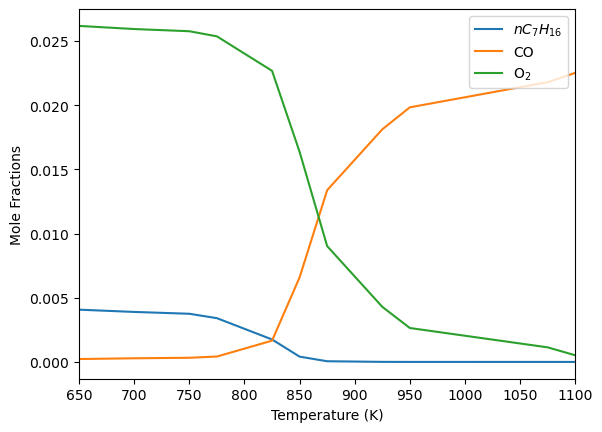

In [7]:
plt.figure()
plt.plot(
    temp_dependence.T, temp_dependence("NC7H16").X, color="C0", label="$nC_{7}H_{16}$"
)
plt.plot(temp_dependence.T, temp_dependence("CO").X, color="C1", label="CO")
plt.plot(temp_dependence.T, temp_dependence("O2").X, color="C2", label="O$_{2}$")

plt.xlabel("Temperature (K)")
plt.ylabel(r"Mole Fractions")

plt.xlim([650, 1100])
plt.legend(loc=1)